In [80]:
import os
import numpy as np
from tifffile import imread
from PIL import Image
from skimage import img_as_float
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

In [82]:
# Define paths
images_folder = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\images"
labels_folder = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\labels"

In [84]:
# Function to normalize an image (multispectral normalization)
def normalize_image(image):
    return img_as_float(image)  # Convert image to float [0, 1] range

# Load and normalize images and labels
images = []
labels = []

for i in range(306):
    image_path = os.path.join(images_folder, f'{i}.tif')
    label_path = os.path.join(labels_folder, f'{i}.png')
    
    # Load and normalize image
    image = imread(image_path)  # Load the 12-band image
    image = normalize_image(image)
    images.append(image)
    
    # Load and normalize label
    label = np.array(Image.open(label_path))  # Load the binary mask label
    if label.max() > 1:  # Check if normalization is needed
        label = label / 255.0
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Check data integrity
assert images.shape == (306, 128, 128, 12), "Image dimensions do not match expected shape."
assert labels.shape == (306, 128, 128), "Label dimensions do not match expected shape."
unique_values = np.unique(labels)
assert set(unique_values) <= {0, 1}, "Labels contain non-binary values."

print("Data loaded and normalized successfully.")
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')


Data loaded and normalized successfully.
Images shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128)


In [85]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set: X={X_train.shape}, y={y_train.shape}')
print(f'Validation set: X={X_val.shape}, y={y_val.shape}')
print(f'Test set: X={X_test.shape}, y={y_test.shape}')

Training set: X=(214, 128, 128, 12), y=(214, 128, 128)
Validation set: X=(46, 128, 128, 12), y=(46, 128, 128)
Test set: X=(46, 128, 128, 12), y=(46, 128, 128)


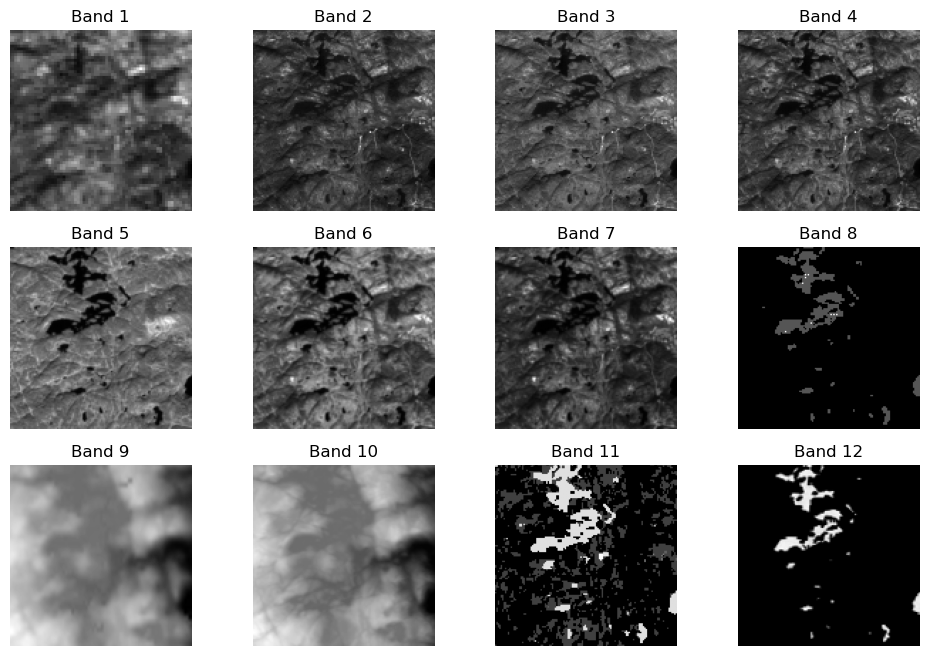

In [88]:
import matplotlib.pyplot as plt

# Visualize the first band of the first image
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[0, :, :, i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')
plt.show()

In [90]:
def advanced_augment(image, label):
    # Expand the label dimensions to match the required 3D shape
    label = tf.expand_dims(label, axis=-1)
    
    # Random flip (horizontal and vertical)
    image = tf.image.random_flip_left_right(image)
    label = tf.image.random_flip_left_right(label)
    
    image = tf.image.random_flip_up_down(image)
    label = tf.image.random_flip_up_down(label)
    
    # Random rotation (90-degree increments)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    label = tf.image.rot90(label, k=k)
    
    # Random brightness and contrast adjustments (only on the image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random zoom and crop
    image = tf.image.resize_with_crop_or_pad(image, 140, 140)
    label = tf.image.resize_with_crop_or_pad(label, 140, 140)
    
    image = tf.image.random_crop(image, size=[128, 128, 12])
    label = tf.image.random_crop(label, size=[128, 128, 1])
    
    # Random Gaussian noise (only on the image)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = tf.cast(image, tf.float32)  # Ensure image is also float32
    image = tf.add(image, noise)
    
    # Squeeze the label to remove the extra dimension
    label = tf.squeeze(label, axis=-1)
    
    return image, label

# Apply advanced augmentation to the training set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(advanced_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Validation and test datasets (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

print("Data augmentation applied and datasets prepared.")


Data augmentation applied and datasets prepared.


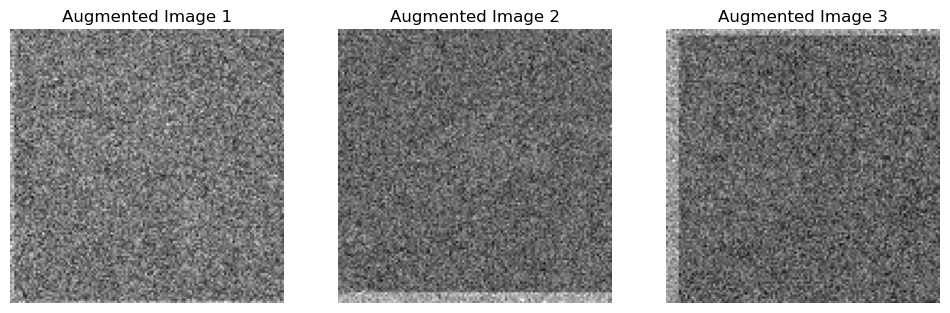

In [92]:
# Visualize the first band's original and augmented versions
plt.figure(figsize=(12, 8))
for images_batch, labels_batch in train_dataset.take(1):
    for i in range(3):  # Displaying 3 examples of augmentation
        plt.subplot(1, 3, i+1)
        plt.imshow(images_batch[i, :, :, 0], cmap='gray')  # Display the first band
        plt.title(f'Augmented Image {i+1}')
        plt.axis('off')
plt.show()

In [94]:
def unet_model_with_optimizations(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling path)
    c1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(128, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(256, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.3)(p3)

    c4 = layers.Conv2D(512, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(512, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.3)(p4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Decoder (Upsampling path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(512, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(256, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Conv2D(128, (3, 3), padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Conv2D(64, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net model with batch normalization and dropout
input_shape = (128, 128, 12)  # 12 channels from the multispectral data
model = unet_model_with_optimizations(input_shape)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 12)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_38 (Conv2D)            │ (None, 128, 128, 64)      │           6,976 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 128, 128, 64)      │             256 │ conv2d_38[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_18 (Activation)    │ (None, 128, 128, 64)      │               0 │ batch_normalization_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_39 (Conv2D)            │ (None, 128, 128, 64)      │          36,928 │ activation_18[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 128, 128, 64)      │             256 │ conv2d_39[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_19 (Activation)    │ (None, 128, 128, 64)      │               0 │ batch_normalization_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 64, 64, 64)        │               0 │ activation_19[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 64, 64, 64)        │               0 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 64, 64, 128)       │             512 │ conv2d_40[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_20 (Activation)    │ (None, 64, 64, 128)       │               0 │ batch_normalization_20[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 64, 64, 128)       │         147,584 │ activation_20[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_21        │ (None, 64, 64, 128)       │             512 │ conv2d_41[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_21 (Activation)    │ (None, 64, 64, 128)       │               

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    verbose=1
)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 98s 11s/step - accuracy: 0.6606 - loss: 0.6714 - mean_io_u_2: 0.3787 - val_accuracy: 0.7360 - val_loss: 0.6778 - val_mean_io_u_2: 0.3583
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 11s/step - accuracy: 0.7446 - loss: 0.5494 - mean_io_u_2: 0.3790 - val_accuracy: 0.3256 - val_loss: 2.7452 - val_mean_io_u_2: 0.3992
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.7913 - loss: 0.4843 - mean_io_u_2: 0.3786 - val_accuracy: 0.3765 - val_loss: 1.9408 - val_mean_io_u_2: 0.3940
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.7835 - loss: 0.4780 - mean_io_u_2: 0.3793 - val_accuracy: 0.5017 - val_loss: 3.9526 - val_mean_io_u_2: 0.5573
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 11s/step - accuracy: 0.7940 - loss: 0.4681 - mean_io_u_2: 0.3782 - val_accuracy: 0.4587 - val_loss: 3.0290 - val_mean_io_u_2: 0.5095
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.7980 - loss: 0.4592 - mean_io_u_2: 0.3786 - val_accuracy: 0.4077 - val_l

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_iou = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU: {test_iou}')

In [ ]:
# Visualize predictions on a few test images
plt.figure(figsize=(12, 12))
for images_batch, labels_batch in test_dataset.take(1):
    predictions = model.predict(images_batch)
    for i in range(3):  # Display 3 predictions
        plt.subplot(3, 3, i*3+1)
        plt.imshow(images_batch[i, :, :, 0], cmap='gray')  # Original image (first band)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(labels_batch[i], cmap='gray')  # Ground truth label
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')  # Predicted mask
        plt.title('Predicted Mask')
        plt.axis('off')
plt.show()